<a href="https://colab.research.google.com/github/acmoral/QuantumGenerativeBaselines/blob/master/QRBM/QRBM_Implementation_and_Theory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Restricted Boltzmann machines and Quantum Computing
##A revision of Marek subocz QRBM implementation


Universidad Nacional de Colombia

Sergio Quiroga Sandoval, squirogas@unal.edu.co

This notebook gathers some basic theory on restricted Boltzmann machines (RBM) and presents a review with minor modifications of a Quantum implementation (MSQRBM) from [Marec Subocz ](https://github.com/mareksubocz/QRBM) github.



## Libraries and imports

In [ ]:
!pip install dwave.system
!pip install pyqubo
!pip install dwave-tabu
!pip install tensorflow

In [ ]:
from dwave.system.composites import EmbeddingComposite
from dwave.system.samplers import DWaveSampler

from pyqubo import Binary
import tabu

import copy
import operator
import random
import sys
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'gray'
import numpy as np
import timeit

import pandas as pd
import cv2 as cv
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
from skimage import img_as_bool
from tqdm import tqdm_notebook as tqdm

#from qrbm.MSQRBM import MSQRBM
#from qrbm.classicalRBM import classicalRBM

In [ ]:
# For using real D-wave devices run this cell and turn qpu flag variable to True when calling MSQRBM.
# Not available in all countries...
#!dwave setup --auth

## Classical RBM theory and Math: energy and model probability and CD1

The following is the graph of a general Restricted Boltzmann Machine, it is a Graphical model that uses a hiden layer of

In [ ]:
# A RBM Graph for hidden and visible layers visualization, taken from:
# Oh, S., Baggag, A., & Nha, H. (2020). Entropy, Free Energy, and Work of Restricted Boltzmann Machines. Entropy (Basel, Switzerland), 22(5), 538. https://doi.org/10.3390/e22050538
from IPython.display import Image
from IPython.core.display import HTML
Image(url= "https://cdn.ncbi.nlm.nih.gov/pmc/blobs/6a14/7517032/80d72a744355/entropy-22-00538-g001.jpg")

Following Geoffrey Hinton’s practical guide for training RBMs:

A Restricted Boltzmann Machine assigns an energy to each joint configuration $(v,h)$ of binary visible and hidden units; the energy formulation traces to Hopfield’s work on neural networks (Hopfield, 1982). In summation notation the energy is written as

$$
E(v,h)
\;=\;
- \sum_{i\in\text{visible}} a_i\, v_i
\;-\; \sum_{j\in\text{hidden}} b_j\, h_j
\;-\; \sum_{i\in\text{visible}}\sum_{j\in\text{hidden}} v_i\,h_j\,w_{ij},
$$

where $v_i,h_j\in\{0,1\}$ are the binary states of visible unit $i$ and hidden unit $j$; $a_i$ and $b_j$ are visible and hidden biases respectively; and $w_{ij}$ is the weight coupling visible $i$ to hidden $j$.

This energy induces a Boltzmann distribution over joint states:

$$
p_\theta(v,h) \;=\; \frac{\exp\!\big(-E(v,h)\big)}{Z}, \qquad
Z \;=\; \sum_{v,h} \exp\!\big(-E(v,h)\big),
$$

and the marginal probability of a visible vector is obtained by summing out the hidden states:

$$
p_\theta(v) \;=\; \frac{1}{Z}\sum_{h} \exp\!\big(-E(v,h)\big).
$$

Because the partition function $Z$ sums over exponentially many configurations, exact maximum-likelihood learning is infeasible except for the smallest models. In practice one therefore uses approximate training; the canonical practical method is Contrastive Divergence (CD), of which CD-1 is the simplest useful variant. The exact gradient identity for a weight $w_{ij}$ is

$$
\frac{\partial \log p_\theta(v)}{\partial w_{ij}}
= \langle v_i h_j\rangle_{\text{data}}
- \langle v_i h_j\rangle_{\text{model}},
$$

where $\langle\cdot\rangle_{\text{data}}$ denotes expectation under the data-driven conditional distribution and $\langle\cdot\rangle_{\text{model}}$ denotes expectation under the model’s equilibrium distribution. Because the model expectation is expensive to compute, CD approximates it by running a short Gibbs chain initialized at the data. In the CD-1 approximation the weight update becomes

$$
\Delta w_{ij} \;\approx\; \varepsilon\big(v_i h_j - v'_i h'_j\big),
$$

where $(v,h)$ are the data-driven visible/hidden states (positive phase) and $(v',h')$ are their one-step reconstructions (negative phase); $\varepsilon$ is the learning rate. In code, the positive and negative pairwise statistics are implemented via outer products (`pos_grad = np.outer(v, h)` and `neg_grad = np.outer(v_prim, h_prim)`) and the weight matrix is updated with `W += lr * (pos_grad - neg_grad)` (optionally combined with momentum)—this directly follows the CD-1 recipe and practical recommendations summarized by Hinton.

Sampling / generation proceeds by alternating conditional updates between layers. For binary units the conditional activation probabilities are logistic:

$$
\Pr(h_j=1\mid v) = \sigma\!\Big(b_j + \sum_i v_i w_{ij}\Big),\qquad
\Pr(v_i=1\mid h) = \sigma\!\Big(a_i + \sum_j h_j w_{ij}\Big),
$$

with $\sigma(x)=1/(1+e^{-x})$. A single Gibbs pair used for reconstruction follows

$$
v^{(0)} \xrightarrow{p(h\mid v^{(0)})} h^{(0)} \xrightarrow{p(v\mid h^{(0)})} v^{(1)},
$$

and CD-style training uses the resulting $(v',h')$ to form the negative statistics. Hinton’s guide discusses when to use stochastic binary draws versus using the probabilities directly (practical trade-offs between sampling noise and estimator variance).

For evaluation, reconstruction error (e.g., squared error between data and reconstructions) is a simple and commonly reported diagnostic, but it is not the same as model likelihood and can be misleading. A more principled scalar is the free energy of a visible vector (which can be computed efficiently and cancels the partition function when comparing examples), but the code’s simple evaluation—returning the minimal squared distance between a candidate reconstruction $r$ and a reference set $\mathcal{P}$,

$$
\text{evaluate}(r) \;=\; \min_{p\in\mathcal{P}} \|r-p\|_2^2,
$$

remains an easy-to-compute metric, with the caveat that it does not directly measure generative likelihood.




For training The boltzmann machine, the MSQRBM implementation will use **single-step Contrastive Divergence (CD-1)** with optional momentum and learning-rate decay. For one selected training vector $v$ the intended mathematical steps are:

1. Positive phase — hidden sampling

   $$
   p(h_j{=}1\mid v)=\sigma\!\Big(b_j+\sum_i W_{ij}v_i\Big),\qquad h\sim p(h\mid v).
   $$
2. Positive gradient

   $$
   G^{+}=v\otimes h.
   $$
3. Negative phase — visible reconstruction

   $$
   p(v_i'{=}1\mid h)=\sigma\!\Big(a_i+\sum_j W_{ij}h_j\Big),\qquad v'\sim p(v\mid h).
   $$
4. Negative hidden sampling

   $$
   p(h'_j{=}1\mid v')=\sigma\!\Big(b_j+\sum_i W_{ij}v'_i\Big),\qquad h'\sim p(h\mid v').
   $$
5. Negative gradient

   $$
   G^{-}=v'\otimes h'.
   $$
6. Parameter updates (stochastic approximation with optional momentum $\mu$ and learning rate $\epsilon$)

   $$
   \Delta W=\epsilon\,(G^{+}-G^{-}),\quad
   a\leftarrow a+\epsilon\,(v-v'),\quad
   b\leftarrow b+\epsilon\,(h-h').
   $$

   With momentum the code implements velocity updates of the form

   $$
   V_W \leftarrow \mu V_W + \epsilon\,(G^{+}-G^{-}),\qquad W\leftarrow W+V_W,
   $$

   and analogous updates for $a$ and $b$.


## Sampling method ([sampler.py ](https://github.com/mareksubocz/QRBM/blob/master/qrbm/sampler.py) )

The sampler converts a *conditional inference* step in a bipartite model (visible ↔ hidden) into a small optimization/sampling problem expressed as a Binary Quadratic Model (BQM).
* The BQM is then solved by either:

  * a real D-Wave QPU via an embedding composite, or
  * a classical heuristic solver (`tabu`), depending on the `qpu` flag.
* Two main services are provided:

  1. sample the **opposite** layer conditioned on a fixed layer state.
  2. propose a visible configuration based only on visible biases.

and returns an index-ordered binary vector representing the solver’s selected low-energy configuration — an optimization-style reconstruction rather than a Gibbs-distributed stochastic sample.



Mapping from the RBM to the BQM used by the code

Begin from the RBM joint energy

$$
E(v,h) = -a^\top v \;-\; b^\top h \;-\; v^\top W h,
$$

with $v\in\{0,1\}^{n_v}$, $h\in\{0,1\}^{n_h}$, $a$ visible biases, $b$ hidden biases, and $W$ the weight matrix.

The conditional energy for the hidden layer given a fixed visible $v$ is

$$
E(h \mid v) = - b^\top h - v^\top W h
           = -\sum_{j} \Big(b_j + \sum_{i} v_i W_{ij}\Big)\, h_j.
$$

Because standard RBMs contain no hidden–hidden couplings, $E(h\mid v)$ is linear in the hidden bits $h_j$. The implementation constructs a binary quadratic model (BQM) whose linear coefficients are

$$
\gamma_j \;=\; b_j + \sum_{i} v_i W_{ij},
$$

equivalently $\gamma_j = b_j + \sum_{i:\,v_i=1} W_{ij}$ since $v_i\in\{0,1\}$. The code’s symbolic Hamiltonian therefore equals

$$
H_{\text{cond}}(h) \;=\; -\sum_j \gamma_j\, h_j,
$$

i.e. a purely linear BQM in the unknown hidden variables (no quadratic hidden–hidden terms are constructed).


In [ ]:
def sample_opposite_layer_minorminer(v, layer, weights, opposite_layer: int):
    raise NotImplementedError

def sample_opposite_layer_pyqubo(v, layer, weights, opposite_layer,
                                 qpu=False, chain_strength=2, num_reads=1):
    # initialize Hamiltonian
    H = 0
    H_vars = []

    # initialize all variables (one for each node in the opposite layer)
    for j in range(len(opposite_layer)):
        H_vars.append(Binary(str(j)))

    for i, bias in enumerate(layer):
        # filter only chosen nodes in the first layer
        if not v[i]:
            continue

        # add reward to every connection
        for j, opp_bias in enumerate(opposite_layer):
            H += -1 * weights[i][j] * H_vars[j]

    for j, opp_bias in enumerate(opposite_layer):
        H += -1 * opp_bias * H_vars[j]


    model = H.compile()
    # print(model)
    bqm = model.to_bqm()
    # print(bqm)

    # choose if you want to use real QPU or local simulation
    if qpu: sampler = EmbeddingComposite(DWaveSampler())
    else:   sampler = tabu.TabuSampler()

    # reading num_reads responses from the sampler
    sampleset = sampler.sample(bqm, chain_strength=chain_strength, num_reads=num_reads)
    solution1 = sampleset.first.sample
    # print(solution1)
    solution1_list = [(k, v) for k, v in solution1.items()]
    solution1_list.sort(key=lambda tup: int(tup[0]))  # sorts in place
    solution1_list_final = [v for (k, v) in solution1_list]
    return solution1_list_final


def sample_v(layer, qpu=False, chain_strength=10, num_reads=1):
    H = 0

    for i, bias in enumerate(layer):
        H += -1 * bias * Binary(str(i))

    model = H.compile()
    bqm = model.to_bqm()

    # choose if you want to use real QPU or local simulation
    if qpu: sampler = EmbeddingComposite(DWaveSampler())
    else:   sampler = tabu.TabuSampler()

    # reading num_reads responses from the sampler
    sampleset = sampler.sample(bqm, chain_strength=chain_strength, num_reads=num_reads)
    solution1 = sampleset.first.sample
    # print(solution1)
    solution1_list = [(k, v) for k, v in solution1.items()]
    solution1_list.sort(key=lambda tup: int(tup[0]))  # sorts in place
    solution1_list_final = [v for (k, v) in solution1_list]
    return solution1_list_final

if __name__ == "__main__":

    # example from https://www.youtube.com/watch?v=Fkw0_aAtwIw (22:50)
    v = [0,1,0]
    layer = [1,1,1]
    weights = [[2,-2], [-4, 4], [2,-2]]
    opp_layer = [2,1]

    sampleset = sample_opposite_layer_pyqubo(v, layer, weights, opp_layer,
                                             qpu=False) # Changed from True to False
    sampleset2 = sample_v(layer, qpu=False) # Changed from True to False
    print(sampleset)
    print(sampleset2)

    # using the best (lowest energy) sample
    # Removed the lines below as sampleset is a list, not a sampleset object
    # solution1 = sampleset.first.sample
    # print(solution1)
    # solution1_list = [(k, v) for k, v in solution1.items()]
    # solution1_list.sort(key=lambda tup: int(tup[0]))  # sorts in place
    # solution1_list_final = [v for (k, v) in solution1_list]

[np.int8(0), np.int8(1)]
[np.int8(1), np.int8(1), np.int8(1)]


## MSQRBM algorithm



MSQRBM uses the hybrid classical/quantum sampler to implement a Restricted Boltzmann Machine (RBM) style model in which the visible layer `v` and the hidden layer `h` are binary vectors. The implemented MSQRBM:

* stores model parameters (weights and biases).
* trains with single-step Contrastive Divergence (CD-1) using an external sampler.
* can generate new visible samples via Gibbs steps that call the sampler.
* evaluates generated samples against MNIST reference pictures.


The Training code:

* **delegates** sampling to an external routine (`sample_opposite_layer_pyqubo` / sampler): the code calls that routine to obtain $h$, $v'$ and $h'$ rather than performing explicit sigmoid+Bernoulli draws in-place;
* computes `pos_grad = np.outer(v,h)` and `neg_grad = np.outer(v_prim,h_prim)` and applies the momentum-augmented updates shown above;
* implements learning-rate decay by multiplicative factor `lr *= (1-lr_decay)` when the epoch index satisfies a periodic condition based on `epoch_drop`;
* records a diagnostic reconstruction error per epoch as a proxy metric: $\sum_i (v_i - \hat v_i)^2$.


In [ ]:
# Sigmoid activation function used to convert linear inputs into probabilities. σ(x) = 1 / (1 + exp(-x)).
def sigmoid(x):
    result = 1 / (1 + np.exp(-x))
    return result

class MSQRBM:
    def __init__(self,
                 n_visible,
                 n_hidden,
                 err_function='mse',
                 qpu=False,
                 chain_strength=5,
                 use_tqdm=True,
                 tqdm=None,
                 result_picture_tab = None):

        # Validate error function selection early to fail fast if misconfigured.
        if err_function not in {'mse', 'cosine'}:
            raise ValueError('err_function should be either \'mse\' or \'cosine\'')

        # Progress-bar control: store flags and (optionally) a tqdm callable.
        # If use_tqdm=True (or a tqdm object is provided) the training loop will
        # iterate with self.tqdm(...) to display progress.
        self._use_tqdm = use_tqdm
        self._tqdm = None

        if use_tqdm or tqdm is not None:
            from tqdm import tqdm  # import here to avoid hard dependency at module import
            self._tqdm = tqdm

        # Model architecture parameters
        self.n_visible = n_visible          # number of visible units (size of v)
        self.n_hidden = n_hidden            # number of hidden units (size of h)
        self.qpu = qpu                      # whether to use quantum hardware sampler
        self.cs = chain_strength            # chain strength for sampler embedding

        # Model parameters initialization:
        #   - w: weights with shape (n_visible, n_hidden)
        #   - visible_bias: a (length n_visible)
        #   - hidden_bias: b (length n_hidden)
        # Random init in (-1,1) — simple, small-scale randomization.
        self.w = (np.random.rand(self.n_visible, self.n_hidden) * 2 - 1) * 1
        self.visible_bias = (np.random.rand(self.n_visible) * 2 - 1) * 1
        self.hidden_bias = (np.random.rand(self.n_hidden) * 2 - 1) * 1

        # Placeholder for a custom sampler object if desired.
        # self.sampler = Sampler()

        # bookkeeping
        self.n_epoch = 0
        self.result_picture_tab = result_picture_tab

    # Simple accessor to get current model parameters
    def get_weights(self):
        return self.w, \
               self.visible_bias, \
               self.hidden_bias

    # Setter to replace model parameters (use with care; assume correct shapes)
    def set_weights(self, w, visible_bias, hidden_bias):
        self.w = w
        self.visible_bias = visible_bias
        self.hidden_bias = hidden_bias


    def train(self, training_data, len_x=1, len_y=1, epochs=50, lr=0.1, lr_decay=0.1, epoch_drop = None, momentum = 0, batch_size = None):
        """
            Train using single-step Contrastive Divergence (CD-1) with optional momentum.
            Steps implemented per-epoch:
              1) select training sample v (cyclic selection using epoch % len(training_data))
              2) sample h ~ p(h|v) using external sampler (positive phase)
              3) compute pos_grad = v ⊗ h
              4) reconstruct v' from h (negative phase) and resample h'
              5) compute neg_grad = v' ⊗ h'
              6) update weights/biases with lr and optional momentum
            Notes/assumptions:
              - This implementation delegates sampling to sample_opposite_layer_pyqubo(...)
              - Learning-curve is tracked as sum-of-squared differences between v and reconstruction
        """
        learning_curve_plot = []

        # Default epoch_drop: one-fifth of epochs (original code used float division; this value will be used in modulo checks)
        if epoch_drop == None:
            epoch_drop = epochs / 5

        # Initialize momentum velocities for weights and biases
        momentum_w = np.zeros((len(self.visible_bias), len(self.hidden_bias)))
        momentum_v = np.zeros(len(self.visible_bias))
        momentum_h = np.zeros(len(self.hidden_bias))

        # Iterate through epochs; using self.tqdm(...) if available provides a progress bar.
        for epoch in self.tqdm(range(epochs)):
            # 1. Select the training sample (cyclic selection)
            random_selected_training_data_idx = epoch % len(training_data)
            v = training_data[random_selected_training_data_idx]
            old_v = v  # used for persistent CD style behavior (may be overwritten below)

            # If batch_size is used to implement a simple persistent-like behavior, the code
            # reuses v_prim from previous iteration when not on batch boundary.
            # WARNING: v_prim must be defined from a prior iteration otherwise this raises NameError.
            if batch_size is not None:
                if epoch % batch_size != 0:
                    old_v = v_prim

            # 1.2 Compute hidden activations' probabilities (classical version shown for reference)
            # prob_h = sigmoid(self.hidden_bias + np.dot(v, self.w))
            # h = (np.random.rand(len(self.hidden_bias)) < prob_h).astype(int)

            # Persistent CD behavior: sample h conditioned on old_v using external sampler.
            # Expectation: sample_opposite_layer_pyqubo returns a list/array of 0/1 values.
            h = sample_opposite_layer_pyqubo(old_v, self.visible_bias,
                                                  self.w, self.hidden_bias,
                                                  qpu=self.qpu,
                                                  chain_strength=self.cs)
            # pos_grad: positive phase outer product v ⊗ h
            pos_grad = np.outer(v, h)

            # 3. Reconstruct visible from sampled hidden units (negative phase)
            v_prim = sample_opposite_layer_pyqubo(h, self.hidden_bias,
                                                       self.w.T,
                                                       self.visible_bias,
                                                       qpu=self.qpu,
                                                       chain_strength=self.cs)

            # 3.2 Recompute hidden from reconstruction
            h_prim = sample_opposite_layer_pyqubo(v_prim,
                                                       self.visible_bias,
                                                       self.w, self.hidden_bias,
                                                       qpu=self.qpu,
                                                       chain_strength=self.cs)

            # 4. Negative gradient computed from reconstruction
            neg_grad = np.outer(v_prim, h_prim)

            # 5. Weight update with optional momentum
            momentum_w = momentum * momentum_w + lr * (pos_grad - neg_grad)
            self.w += momentum_w

            # 6. Bias updates with momentum
            momentum_v = momentum * momentum_v + lr * (np.array(v) - np.array(v_prim))
            momentum_h = momentum * momentum_h + lr * (np.array(h) - np.array(h_prim))

            self.visible_bias += momentum_v
            self.hidden_bias += momentum_h

            # Optional: after certain epochs, decay learning rate
            if epoch % epoch_drop == (epoch_drop-1):
                lr *= (1 - lr_decay)

            # Diagnostics: compute reconstruction error for learning curve
            sample_v = v  # here sample_v is treated as the current visible (not as a function)
            sample_h = sample_opposite_layer_pyqubo(sample_v,
                                                         self.visible_bias,
                                                         self.w,
                                                         self.hidden_bias,
                                                         qpu=self.qpu,
                                                         chain_strength=self.cs)
            sample_output = sample_opposite_layer_pyqubo(sample_h,
                                                              self.hidden_bias,
                                                              self.w.T,
                                                              self.visible_bias,
                                                              qpu=self.qpu,
                                                              chain_strength=self.cs)
            learning_curve_plot.append(np.sum((np.array(v) - np.array(sample_output))**2))


        # End of training: plot learning curve (normalised MSE proxy)
        plt.figure()
        plt.plot(learning_curve_plot)
        plt.xlabel('epoch')
        plt.ylabel('normalised MSE')
        plt.show()
        return

    def generate(self, test_img = None):
        # Generate a single reconstruction:
        #  - if test_img is provided use it as initial visible vector; otherwise sample a visible prior
        sample_v = []
        if test_img == None:
            # NOTE: this line intends to call an external function named sample_v(...)
            # but here sample_v is also the target variable name; this mirrors the original code
            sample_v = sample_v(self.visible_bias, qpu=self.qpu,
                                     chain_strength=self.cs)
        else:
            sample_v = test_img

        # Sample hidden conditioned on visible, then reconstruct visible from hidden
        sample_h = sample_opposite_layer_pyqubo(sample_v,
                                                     self.visible_bias, self.w,
                                                     self.hidden_bias,
                                                     qpu=self.qpu,
                                                     chain_strength=self.cs)
        sample_output = sample_opposite_layer_pyqubo(sample_h,
                                                          self.hidden_bias,
                                                          self.w.T,
                                                          self.visible_bias,
                                                          qpu=self.qpu,
                                                          chain_strength=self.cs)
        return sample_output


    def evaluate(self, result, test_img = None):
        # Compute minimal squared-error between `result` and any template in result_picture_tab.
        # Returns scalar min_sum; smaller is better (0 means exact match).
        min_sum = 1000000
        for pic in self.result_picture_tab:
            new_sum = np.sum((np.array(result) - np.array(pic)) ** 2)
            if new_sum < min_sum:
                min_sum = new_sum

        return min_sum

    def save(self, filename):
        # Save model parameters to a human-readable text file.
        with np.printoptions(threshold=sys.maxsize):
            parameters = [str(self.n_hidden),
                          str(self.n_visible),
                          np.array_repr(self.visible_bias),
                          np.array_repr(self.hidden_bias),
                          np.array_repr(self.w)]
            with open(filename, 'w') as file:
                file.write('#'.join(parameters))


    def load(self, filename):
        # Load model parameters produced by save(). This uses eval() to reconstruct arrays.
        with open(filename) as file:
            res = file.read()
            parameters = res.split('#')
            self.n_hidden = eval(parameters[0])
            self.n_visible = eval(parameters[1])
            self.visible_bias = eval('np.'+parameters[2])
            self.hidden_bias = eval('np.'+parameters[3])
            self.w = eval('np.'+parameters[4])


## MNIST images implementation of MSQRBM

Parameters

In [ ]:
# Defining image sizes

image_height = 28
image_width = 28

# images will be flattened
len_x = image_height * image_width
len_y = 0

# Model Parameters
digits = [0, 1]
THRESHOLD = 100
n_hidden = 30
qpu = False
epochs = 1000
lr = 0.1

Dataset preprocessing

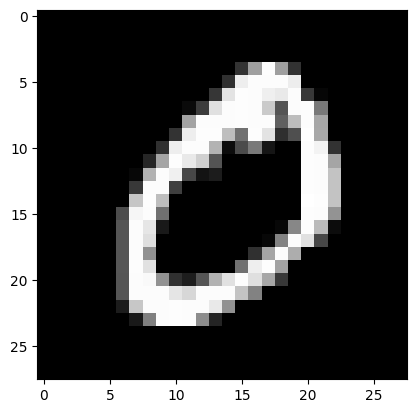

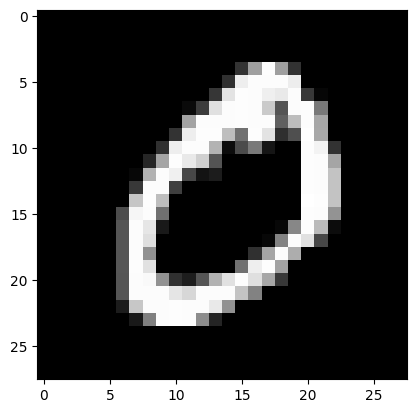

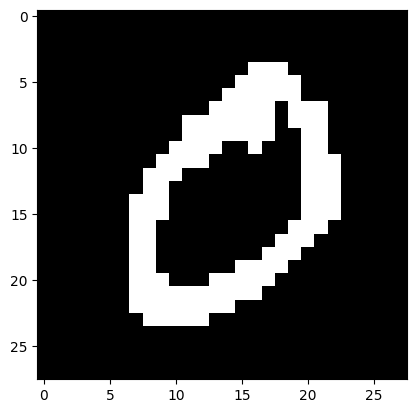

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 

In [ ]:
# reading dataset using tensorflow.keras.datasets.mnist
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Load MNIST dataset directly from tensorflow
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Convert to the same format as the original code
# Create arrays to match the original structure
X_train = x_train.reshape(x_train.shape[0], -1)  # Flatten images
X_test = x_test.reshape(x_test.shape[0], -1)     # Flatten images

# Create combined arrays with labels (similar to original CSV format)
X_train2 = np.column_stack([y_train, X_train])
X_test2 = np.column_stack([y_test, X_test])

# Filter data for specific digits (same as original code)
X_train3 = []
X_test3 = []

for digit in digits:
    train_mask = y_train == digit
    test_mask = y_test == digit
    X_train3.append(X_train[train_mask])
    X_test3.append(X_test[test_mask])

# Since we're using tensorflow's MNIST, the data is already in the correct format
# We just need to normalize it to [0,1] range
imgs = []
imgs_test = []
for digit_index in range(len(digits)):
    # X_train3 and X_test3 are already flattened, so we reshape them back to 28x28
    imgs.append(X_train3[digit_index].reshape(-1, 28, 28) / 255.0)
    imgs_test.append(X_test3[digit_index].reshape(-1, 28, 28) / 255.0)

plt.imshow(imgs[0][0])
plt.show()

# Resizing images
images_resized = []
images_resized_test = []
for digit_index in range(len(digits)):
    images_resized.append([resize(img, (image_width, image_height), anti_aliasing=True) for img in imgs[digit_index]])
    images_resized_test.append([resize(img, (image_width, image_height), anti_aliasing=True) for img in imgs_test[digit_index]])

    # images_resized = [resize(img, (image_width, image_height), anti_aliasing=True) for img in imgs]

# Normalizing images

images_normalized = []
images_normalized_test = []

for digit_index in range(len(digits)):
    images_normalized.append([cv.normalize(image_resized, image_resized, 0, 255, cv.NORM_MINMAX) for image_resized in images_resized[digit_index]])
    images_normalized_test.append([cv.normalize(image_resized, image_resized, 0, 255, cv.NORM_MINMAX) for image_resized in images_resized_test[digit_index]])

    # images_normalized = [cv.normalize(image_resized, image_resized, 0, 255, cv.NORM_MINMAX) for image_resized in images_resized]

plt.imshow(images_normalized[0][0])
plt.show()
#Converting to binary

data = []
data_test = []
for digit_index in range(len(digits)):
    data.append([np.where(image_resized > THRESHOLD, 1, 0) for image_resized in images_resized[digit_index]])
    data_test.append([np.where(image_resized > THRESHOLD, 1, 0) for image_resized in images_resized_test[digit_index]])

# data = [np.where(image_resized > THRESHOLD, 1, 0) for image_resized in images_resized]

plt.imshow(data[0][0])
plt.show()

# Flattening
input_data = []
input_data_test = []
for digit_index in range(len(digits)):
    input_data.append([x.flatten().tolist() for x in data[digit_index]])
    input_data_test.append([x.flatten().tolist() for x in data_test[digit_index]])

print(input_data[0][0])


result_picture_tab = []
for digit_index in range(len(digits)):
    result_picture_tab.append(np.mean(input_data_test[digit_index], axis = 0))
    for digit in digits:
      flat_input_data = [item for sublist in input_data for item in sublist]
      flat_input_data_test = [item for sublist in input_data_test for item in sublist]

random.shuffle(flat_input_data)
random.shuffle(flat_input_data_test)

In [ ]:
# BM Parameters
n_hidden = 30
qpu = False
epochs = 1000
lr = 0.1

#initialization
bm = MSQRBM(n_visible=len_x, n_hidden=n_hidden, qpu=qpu)
bm.image_height = image_height
bm.tqdm = tqdm
bm.result_picture_tab = result_picture_tab

/tmp/ipython-input-4104885449.py:127: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in self.tqdm(range(epochs)):


  0%|          | 0/1000 [00:00<?, ?it/s]

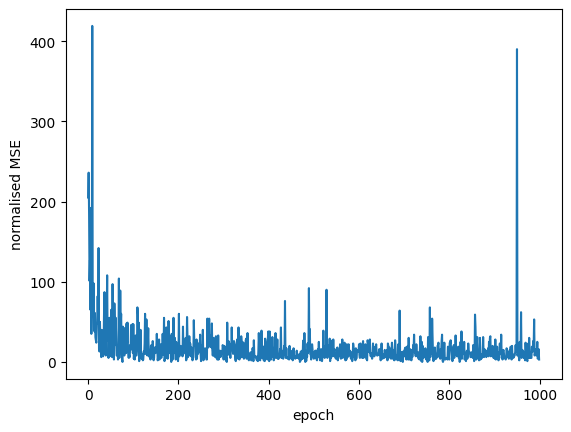

In [ ]:
bm.train(flat_input_data, len_x, len_y, epochs = epochs, lr = lr, lr_decay = 0.1)

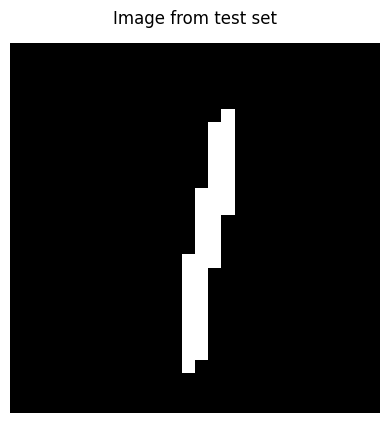

evaluation:  21.68607114440412


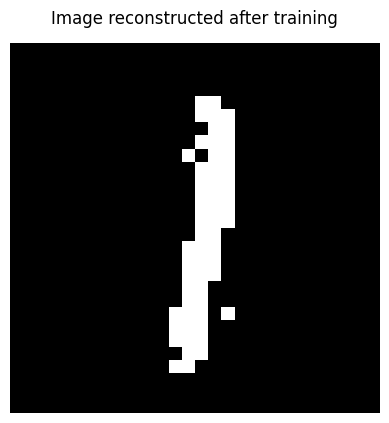

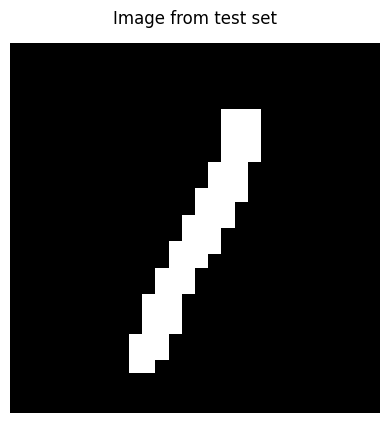

evaluation:  23.828802421937162


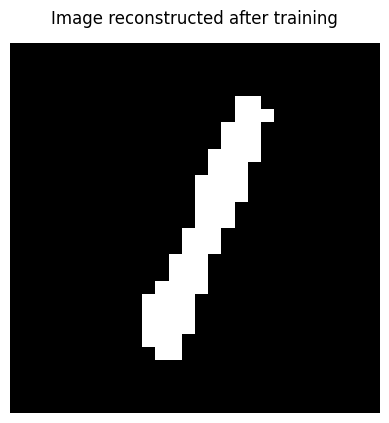

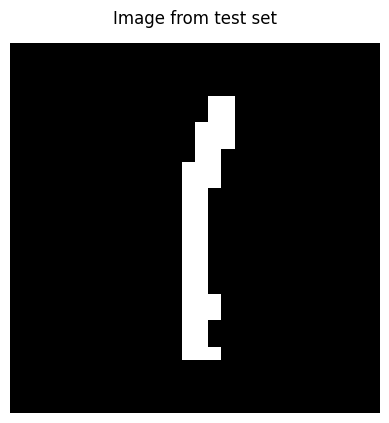

evaluation:  20.44554251004289


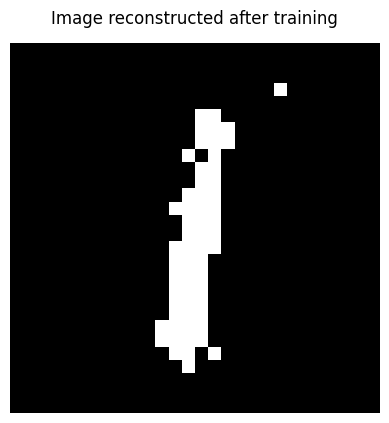

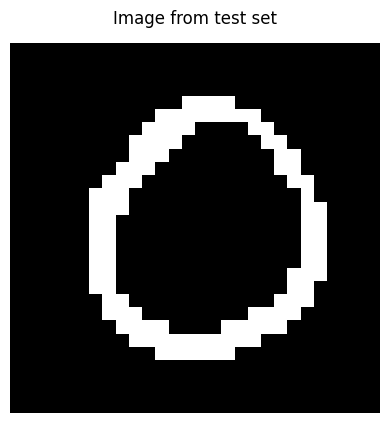

evaluation:  85.02143065389421


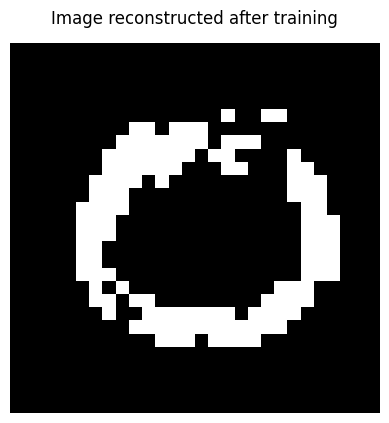

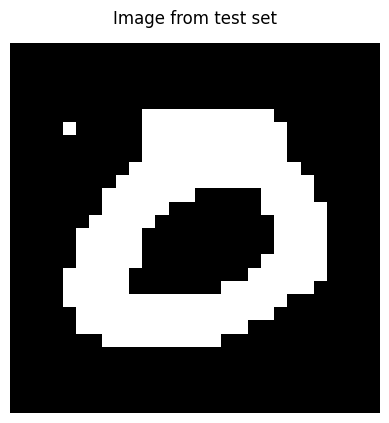

evaluation:  68.71530820491462


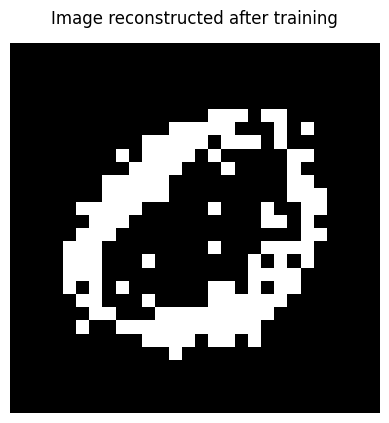

In [ ]:
for test in range(5):
    flat_input_data_test_img = np.reshape(flat_input_data_test[test], (image_width, image_height))
    plt.figure()
    plt.axis('off')
    plt.title("Image from test set", y=1.03)
    plt.imshow(flat_input_data_test_img)
    plt.show()

    generated_pic = bm.generate(test_img = flat_input_data_test[test])
    evaluation = bm.evaluate(generated_pic, flat_input_data_test[test])
    print("evaluation: ", evaluation)
#     print(generated_pic)
    plt.figure()
    plt.axis('off')
    plt.title("Image reconstructed after training", y=1.03)
    plt.imshow(np.array(generated_pic).reshape(image_height, -1))

## Appendix

`generate`

The `generate` method performs one Gibbs pair (or solver-based approximation) and returns the reconstructed visible vector. Let the initial visible configuration be $v^{(0)}$ (provided as `test_img` or produced by the sampler). The method computes

1. hidden sampling (conditioning on $v^{(0)}$):

   $$
   h^{(0)} \approx \arg\min_{h} H_{\text{cond}}(h\mid v^{(0)})\quad\text{or}\quad h^{(0)}\sim p(h\mid v^{(0)}),
   $$

   where $H_{\text{cond}}(h\mid v)= -b^\top h - v^\top W h$.
2. visible reconstruction (conditioning on $h^{(0)}$):

   $$
   v^{(1)} \approx \arg\min_{v} H_{\text{cond}}(v\mid h^{(0)})\quad\text{or}\quad v^{(1)}\sim p(v\mid h^{(0)}),
   $$

   where $H_{\text{cond}}(v\mid h)= -a^\top v - h^\top W^\top v$.

The code uses an external sampler to perform these steps (solver semantics: typically returns low-energy assignments; Gibbs semantics: would return independent Bernoulli draws with probabilities given by the sigmoid). The method returns $v^{(1)}$.

---

`evaluate`

Given a candidate visible vector $r$ and a repository $\mathcal{P}=\text{result\_picture\_tab}$ of reference vectors, the method computes the minimal squared Euclidean distance:

$$
\text{evaluate}(r) \;=\; \min_{p\in\mathcal{P}}\|r-p\|_2^2
\;=\; \min_{p\in\mathcal{P}}\sum_i (r_i-p_i)^2.
$$

The returned scalar is a proximity score (0 indicates an exact match to at least one template).

---
`save` / `load`

* `save` serializes the following fields into a single text record joined by `#`: `n_hidden`, `n_visible`, `visible_bias` (numpy representation), `hidden_bias` (numpy representation) and `w` (numpy representation). The file content is human-readable but structured as Python/numpy literals.
* `load` reconstructs the values by splitting on `#` and using `eval` (with `'np.'` prepended for array literals) to recreate numpy objects.


The following commented methods sketch building a QUBO and sampling from it they are left as comments in the original code and are not executed.

In [ ]:
    # #Qubo is being built, otherwise it probably won't be possible to do it
    # def set_qubo(self):
    #     visible_bias = self.visible_bias
    #     hidden_bias = self.hidden_bias
    #     w = self.w
    #
    #     Q = {}
    #     for i in range(self.n_visible):
    #         Q[(i, i)] = -1 * visible_bias[i]
    #     for j in range(self.n_hidden):
    #         Q[(j + self.n_visible, j + self.n_visible)] = -1 * hidden_bias[j]
    #     for i in range(self.n_visible):
    #         for j in range(self.n_hidden):
    #             Q[(i, self.n_visible + j)] = -1 * w[i][j]
    #     self.Q = Q
    #     # print("qubo: ", self.Q)
    #
    # def get_Z(self):
    #     Z = np.sum(np.exp(-1 * self.energies))
    #     self.Z = Z
    #     return Z
    #
    # # I would handle it myself here
    # def sample_qubo(self, num_samps=100):
    #     if not hasattr(self, 'Q'):
    #         self.set_qubo()
    #     self.samples, self.energies, self.num_occurrences = self.sampler.sample_qubo(self.Q, num_samps=num_samps)
    #     # self.samples, self.energies, self.num_occurrences = self.sampler.sample_qubo(self.Q, num_samps=1)
    #     self.energies /= np.max(np.abs(self.energies))
    #     self.get_Z()
    #     return self.samples

##Conclusions




*   The MSQRBM uses a hybrid quantum/classical sampler for converts a conditional inference step in a bipartite model (visible ↔ hidden) into a small optimization/sampling problem expressed as a Binary Quadratic Model (BQM) that later is implemented on Dwave real quantum annealers.



## References

-  Subocz, M. (n.d.). Mareksubocz/QRBM: Implementation of quantum restricted Boltzmann machine using quantum annealing on D-wave’s QPU. GitHub. https://github.com/mareksubocz/QRBM
-  Krzysztof, K., Mateusz, S., Marek, S., & Rafa\l, R. (2021). Applying a Quantum Annealing Based Restricted Boltzmann Machine for MNIST Handwritten Digit Classification. CMST, 27(3), 99–107.
- Nicholson, C. V. (n.d.). A beginner’s guide to restricted boltzmann machines (rbms) | pathmind. A.I. Wiki. https://wiki.pathmind.com/restricted-boltzmann-machine
- Hinton, G. E. (2012). A practical guide to training restricted boltzmann machines. Lecture Notes in Computer Science, 599–619. https://doi.org/10.1007/978-3-642-35289-8_32
- Models-BQM. Models - Python documentation. (n.d.). https://docs.dwavequantum.com/en/latest/concepts/models.html#concept-models-bqm
- What is contrastive divergence: Ai basics: Ai online course. www.aionlinecourse.com. (n.d.). https://www.aionlinecourse.com/ai-basics/contrastive-divergence